## Detection of correlated input to FS with and without gap junctions.

Here we run one population unit, and steadily increase the input frequency to see roughly what level of activity we should use for the experiment.

In [1]:
import os
import numpy as np

os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example."

network_path = os.path.join("networks", "FS-input-correlation-detection-4-dopamine")
rc = None

In [2]:
from snudda import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=12345)
si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=50, num_LTS=0, num_ChIN=0)

# The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
# First test, we place units on top of each other -- set num_neurons to 8
if False:
    si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=1, 
                                   unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 100e-6, 0]),
                                   probability_function="(d < 300e-6)*1", num_neurons=20)
    si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=2, 
                                   unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 0, 100e-6]),
                                   probability_function="(d < 300e-6) * 1", num_neurons=20)
else:
    si.add_population_unit_random(structure_name="Striatum", neuron_types=["FS"], fraction_of_neurons=1, unit_id=1)
    
si.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs
Writing networks/FS-input-correlation-detection-4-dopamine/network-config.json


In [3]:
# Smaller network -- TESTING
if False:
    from snudda import SnuddaInit
    si = SnuddaInit(network_path=network_path, random_seed=12345)
    si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=10, num_LTS=0, num_ChIN=0)

    # The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
    # First test, we place units on top of each other -- set num_neurons to 8
    si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=1, 
                                   unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 100e-6, 0]),
                                   probability_function="(d < 300e-6)*1", num_neurons=4)
    si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=2, 
                                   unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 0, 100e-6]),
                                   probability_function="(d < 300e-6) * 1", num_neurons=4)

    si.write_json()

In [4]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

### Plotting the network
Plotting the network to verify that the population units are placed the way we expect.

Population unit 1 has 50 neurons


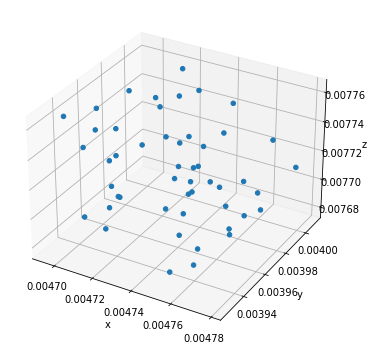

In [5]:
from snudda.plotting import PlotNetwork
pos_file = os.path.join(network_path, "network-neuron-positions.hdf5")

pn = PlotNetwork(pos_file)
pn.plot_populations()

# The commented code below also plots the network, but with the option to plot more detail of the neurons:
# pn = PlotNetwork(network_path)
# pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False, colour_population_unit=True)

pn.close()  # Close the hdf5 file so others can use it (or better shut down kernel after)

### Check if ipyparallel running
For larger networks it is useful to run network creation in parallel.

In [6]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

Warning, running in serial.


In [7]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc, verbose=False)
sd.detect()

No d_view specified, running distribute neurons in serial
Processing hyper voxel : 115/336 (50 neurons)
Processing hyper voxel : 163/336 (50 neurons)
Processing hyper voxel : 171/336 (48 neurons)
Processing hyper voxel : 116/336 (46 neurons)
Processing hyper voxel : 123/336 (45 neurons)
Processing hyper voxel : 164/336 (44 neurons)
Processing hyper voxel : 124/336 (36 neurons)
Processing hyper voxel : 155/336 (34 neurons)
Processing hyper voxel : 162/336 (34 neurons)
Processing hyper voxel : 107/336 (33 neurons)
Processing hyper voxel : 172/336 (30 neurons)
Processing hyper voxel : 114/336 (26 neurons)
Processing hyper voxel : 156/336 (25 neurons)
Processing hyper voxel : 108/336 (24 neurons)
Processing hyper voxel : 122/336 (19 neurons)
Processing hyper voxel : 170/336 (18 neurons)
Processing hyper voxel : 67/336 (17 neurons)
Processing hyper voxel : 211/336 (16 neurons)
Processing hyper voxel : 212/336 (15 neurons)
Processing hyper voxel : 154/336 (14 neurons)
Processing hyper voxel 

In [8]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc, verbose=False)
sp.prune()

Read 42825 out of total 42825 synapses
Read 5680 out of total 5680 gapJunctions


### Generate input

Next we generate the input according to specifications in [FS-input-correlation-detection-4.json](FS-input-correlation-detection-4.json)

Here each FS neuron receives 100 extra cortical inputs (```nInputs=100```) at 7.5Hz. The correlation is 0.7 (```populationUnitCorrelation=0.7```), and the two first seconds are discarded. For five seconds the correlation is only within the neuron (```populationUnitCorrelationFactor=0```), then the following five seconds the correlation is within the population unit (```populationUnitCorrelationFactor=1```). Then another five seconds of correlation within the neuron only, and then five seconds with correlation within the population unit .

In [9]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=os.path.join("FS-input-correlation-detection-4.json"),
                 time=22,
                 rc=rc, verbose=False)
si.generate()

Loading 50 neurons with 4995 synapses and 3443 gap junctions
Writing spikes to networks/FS-input-correlation-detection-4-dopamine/input-spikes.hdf5


### Plot the input to verify it looks reasonable

In [10]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)

Loading 50 neurons with 4995 synapses and 3443 gap junctions


Input to FS population unit 1. We successively increase the input frequency for cortical signal every 2 seconds. The second half of each period has correlation between the units with the population unit, the first does not (correlation is then only within the neuron).

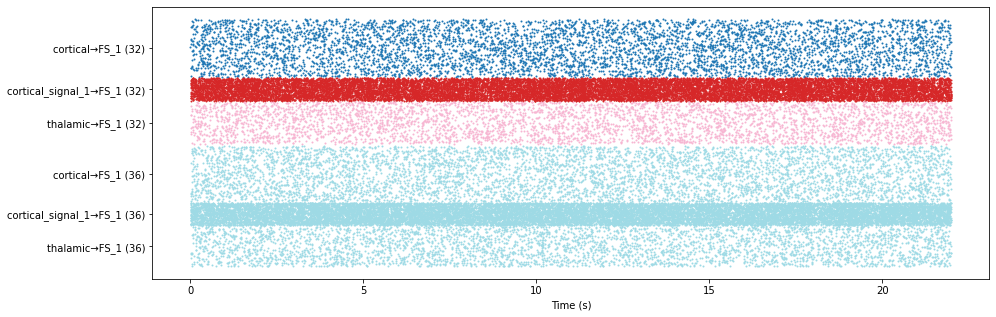

In [11]:
spi.plot_input_population_unit(population_unit_id=1, num_neurons=2, neuron_type="FS", fig_size=(15,5))

Setup neuromodulation, see example https://github.com/jofrony/Neuromodulation-software/blob/main/examples/Example-replay-neuromodulation.ipynb

In [12]:
from snudda.neuromodulation.modulation_network import Neuromodulation

nl = Neuromodulation()
nl.set_timestep(dt=0.025)
nl.set_modulation(neurotransmitter = 'dopamine', neurotransmitter_key = 'DA')
# Duration is the duration of the entire simulation (in milliseconds)
nl.transient(neurotransmitter='dopamine',\
             method='alpha_repetition',\
             duration= 22000,\
             parameters={"tstart" : [12000, 17000], "gmax" : 1, "tau" : 300})

nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'dSPN',\
                          section = 'soma',\
                          ion_channels = ["cal12_ms","cal13_ms","kir_ms","kas_ms","naf_ms","can_ms"])
nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'dSPN',\
                          section = 'dendrite',\
                          ion_channels = ["kir_ms","kas_ms","kaf_ms","cal12_ms","cal13_ms"])
nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'dSPN',\
                          section = 'axon',\
                          ion_channels = [])

nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'iSPN',\
                          section = 'soma',\
                          ion_channels = ["kir_ms","kas_ms","kaf_ms","naf_ms","cal12_ms","cal13_ms", "can_ms","car_ms"])
nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'iSPN',\
                          section = 'dendrite',\
                          ion_channels = ["kir_ms","kas_ms","kaf_ms","naf_ms","cal12_ms","cal13_ms", "can_ms","car_ms"])
nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'iSPN',\
                          section = 'axon',\
                          ion_channels = ["kir_ms","kas_ms","kaf_ms","naf_ms","cal12_ms","cal13_ms", "can_ms","car_ms"])

nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'FS',\
                          section = 'soma',\
                          ion_channels = ['kir_fs','kas_fs','kaf_fs','naf_fs'])
nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'FS',\
                          section = 'dendrite',\
                          ion_channels = ['kir_fs'])
nl.ion_channel_modulation(neurotransmitter = 'dopamine',\
                          cell_type = 'FS',\
                          section = 'axon',\
                          ion_channels = [])


nl.save(dir_path=network_path,name='dopamine_modulation.json')

### Compile neuron modules

In [13]:
!nrnivmodl ../../../../BasalGangliaData/data/neurons/mechanisms

/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "../../../../BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/bk_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/bk_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/ca_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal12_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal13_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/caldyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/can_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/can_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cap_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/caq_fs.mod" "../

### Run the simulation

If you run the ```snudda simulate``` command in a terminal window, make sure to set ```SNUDDA_DATA``` using ```export SNUDDA=/path/to/BasalGangliaData```

In [ ]:
!mpiexec -n 6 snudda simulate networks/FS-input-correlation-detection-4-dopamine --time 22 --neuromodulation networks/FS-input-correlation-detection-4-dopamine/dopamine_modulation.json --verbose

Loading networks/FS-input-correlation-detection-4-dopamine/simulation/output.hdf5


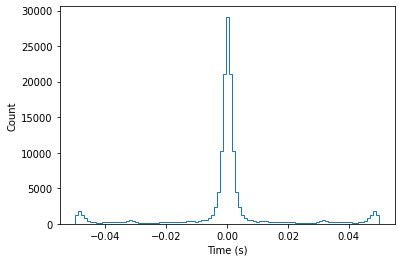

<Figure size 432x288 with 0 Axes>

In [14]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram
pcc1 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output.hdf5"))
pcc1.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr.png"))

Loading 50 neurons with 4995 synapses and 3443 gap junctions
Loading networks/FS-input-correlation-detection-4-dopamine/simulation/output.hdf5
Saving figure to networks/FS-input-correlation-detection-4-dopamine/figures/spike-raster-gj.pdf


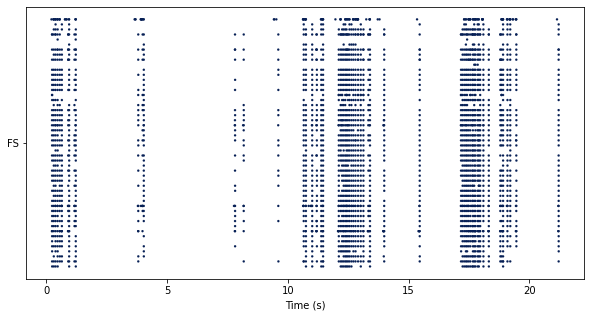

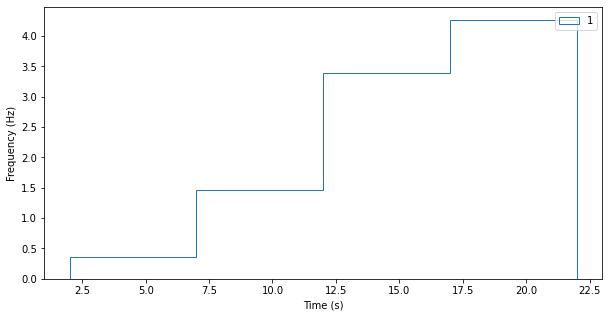

In [15]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file = os.path.join(network_path, "simulation", "output.hdf5")
fig_file = os.path.join(network_path, "figures", "spike-raster-gj.pdf")
spr = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file, figure_path=fig_file)
spr.plot_spike_raster(fig_size=(10,5))
spr.plot_spike_histogram(bin_size=5000e-3, skip_time=2, end_time=23, fig_size=(10,5))

In [ ]:
!mpiexec -n 6 snudda simulate networks/FS-input-correlation-detection-4-dopamine --time 22 --disableGJ --outputFile networks/FS-input-correlation-detection-4-dopamine/simulation/output-no-GJ.hdf5 --neuromodulation networks/FS-input-correlation-detection-4-dopamine/dopamine_modulation.json

In [2]:
pcc2 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output-no-GJ.hdf5"))
pcc2.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr-no-gj.png"))

NameError: name 'PlotCrossCorrelogram' is not defined

Loading 50 neurons with 4995 synapses and 3443 gap junctions
Loading networks/FS-input-correlation-detection-4-dopamine/simulation/output-no-GJ.hdf5
Saving figure to networks/FS-input-correlation-detection-4-dopamine/figures/spike-raster-no-gj.pdf


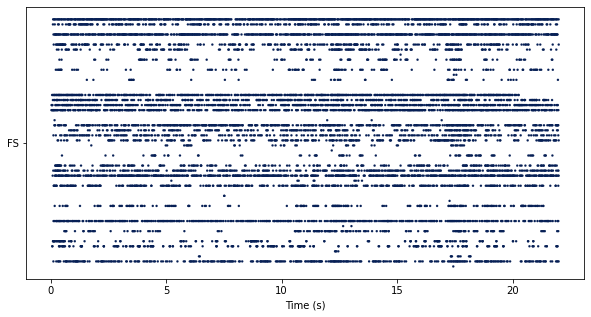

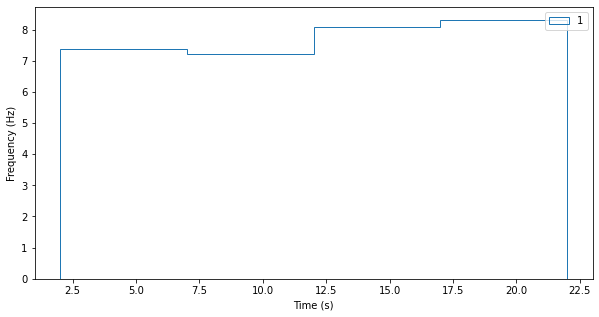

In [3]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file_no_gj = os.path.join(network_path, "simulation", "output-no-GJ.hdf5")
fig_file_no_gj = os.path.join(network_path, "figures", "spike-raster-no-gj.pdf")
spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file_no_gj, figure_path=fig_file_no_gj)
spr2.plot_spike_raster(fig_size=(10,5))
spr2.plot_spike_histogram(bin_size=5, skip_time=2, end_time=23, fig_size=(10,5))

### Plotting

We want to see what frequency we should have the cortical input at to get gap junction case to spike.